# Noise2Void - 2D Example

In [3]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [5]:
base_dir = '/Volumes/USER_data/Dominik/CECELIA_BACKUP/CV5iNI/ANALYSIS/'
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'fmjlDg')

In [75]:
# load all images from training test set
uids = [
    'lF42oB', 'lATpf9', '3MRjU4', 'qOxIDy', 'VjLmSX', '9wXzES', 'yJTSI0', 'OUmImo', 'ekj7Zb', 'JxAGL1', '0YBtV1', 'fL4HVa', 'tW6Mvn', 'vr6Keb', 'RRnkT7', 'hcOuJ7', 'gLdGSK', 'XryFOM', 'xZk3Cv', 'XaOf7a', 'Onl5sH', 'NCluxs', 'zuLDn4', '2MX6eS', 'lhJJTQ', 'SxsYGh', 'UG0alP', '9yu38D', 'OXHYrr', 'zoYrJH', 'fq685L', 'kMyBGk', 'dKyxos', '2YrBlr', 'OJzLis', 'MRJHVV', 'PQQ3IT', 'b5gSPq', 'hdrlDI', 'DMtgyZ', 'zrBJR3', 'DjEB2I', 'tbDjbi', '5FHk7b', 'bDLXNX', 'rayDgy', 'bfmWDq', 'REQ489', 'wIFQwV', 'vOhiHR', '51jX2x', 'mobEM6', 'GbDQSM', '9Iihgs', 'Oay85y', 'ZorIiT', 'i8BYwx', 'xkJ0EG', 'OJRUUP', 'k8RGHZ', 'yUktKc', 'z5637j', 'hodCfw', 'xX3sm7', 'i3emOF', 'jRStzi', 'eNwb0m', 'lPOF17', 'gikrsk', 'gwYhCm'
]

In [76]:
import py.zarr_utils as zarr_utils

# get zarr
# imgs = {i: zarr_utils.open_as_zarr(os.path.join(base_dir, '0', i, 'ccidImage.zarr')) for i in uids}
imgs = [zarr_utils.open_as_zarr(os.path.join(base_dir, '0', i, 'ccidImage.zarr')) for i in uids]

# get arrays
# imgs = {i: np.squeeze(np.array(zarr_utils.fortify(x[0]))) for i, x in imgs.items()}
imgs = [np.squeeze(np.array(zarr_utils.fortify(x[0]))) for x in imgs]

# add time
imgs = [np.expand_dims(x, axis = 0) for x in imgs]

# add RGB
imgs = [np.expand_dims(x, axis = 3) for x in imgs]

<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<zarr.hierarchy.Group '/' read-only>
<

In [77]:
# Here we extract patches for training and validation.
patch_shape = (64, 64)
#patch_shape = (128, 128)

patches = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)

Generated patches: (512, 64, 64, 1)


In [78]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
split_val = round(len(patches) * 0.8)
X = patches[:split_val]
X_val = patches[split_val:]

train_steps_per_epoch = int(X.shape[0]/64)
#train_steps_per_epoch = int(X.shape[0]/16)

(len(X), len(X_val))

(410, 102)

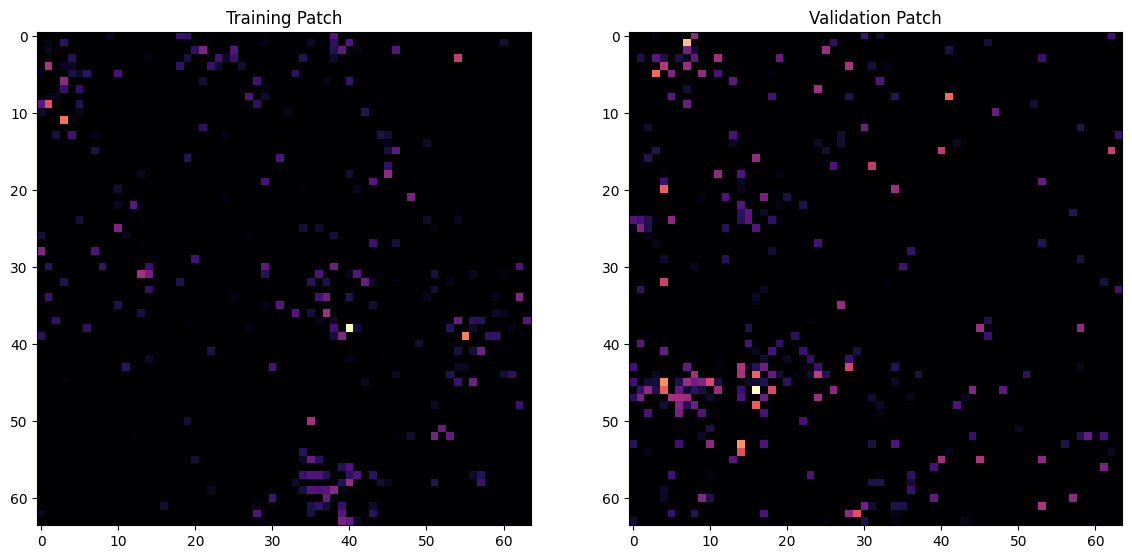

In [79]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [80]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=train_steps_per_epoch,train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['1.9789610327743903'],
 'stds': ['9.877885206164164'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 25,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [81]:
# a name used to identify the model
model_name = 'n2v_2D_3P_ubiTom'

# the base directory in which our model will live
basedir = '/Users/Dominik/Downloads/n2v'

# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

## Training

In [82]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|████████████████████████████████████████████████| 102/102 [00:00<00:00, 1449.46it/s]

Epoch 1/20


25/25 [==============================] - 10s 257ms/step - loss: 1.4134 - n2v_mse: 1.4134 - n2v_abs: 0.6815 - val_loss: 1.1317 - val_n2v_mse: 2.6138 - val_n2v_abs: 0.4214 - lr: 4.0000e-04
Epoch 2/20
25/25 [==============================] - 6s 228ms/step - loss: 1.9288 - n2v_mse: 1.9288 - n2v_abs: 0.5163 - val_loss: 1.0636 - val_n2v_mse: 2.3869 - val_n2v_abs: 0.4069 - lr: 4.0000e-04
Epoch 3/20
25/25 [==============================] - 6s 236ms/step - loss: 1.0635 - n2v_mse: 1.0635 - n2v_abs: 0.4955 - val_loss: 0.9919 - val_n2v_mse: 2.0841 - val_n2v_abs: 0.4245 - lr: 4.0000e-04
Epoch 4/20
25/25 [==============================] - 5s 215ms/step - loss: 1.6548 - n2v_mse: 1.6548 - n2v_abs: 0.5250 - val_loss: 0.9920 - val_n2v_mse: 2.0854 - val_n2v_abs: 0.4557 - lr: 4.0000e-04
Epoch 5/20
25/25 [==============================] - 6s 222ms/step - loss: 0.8566 - n2v_mse: 0.8566 - n2v_abs: 0.3939 - val_loss: 0.9831 - val_n2v_mse: 2.0262 - val_n2v_abs: 0.4487 - lr: 4.0000e-04
Epoch 6/20
25/25 [=======

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


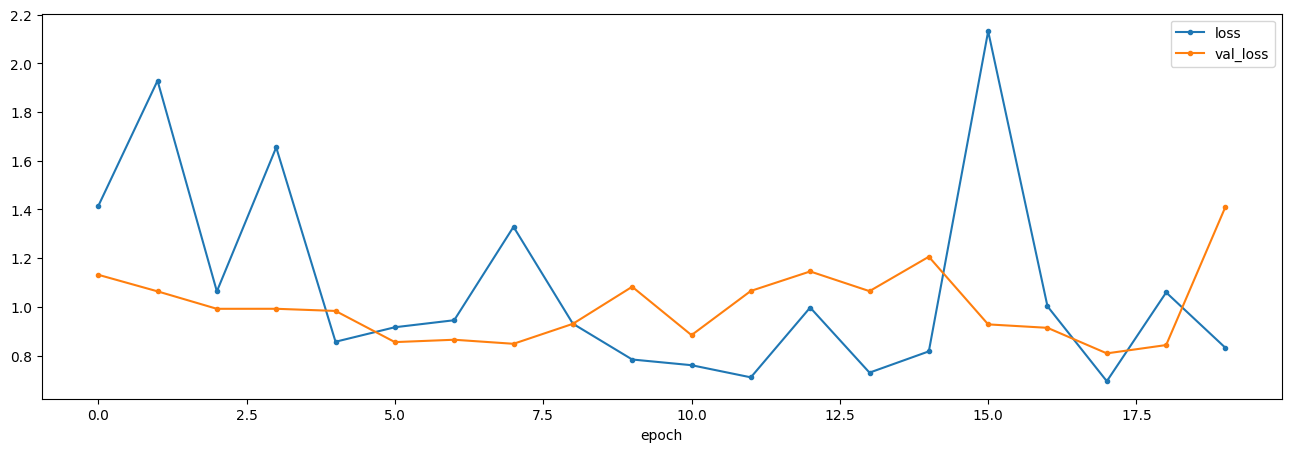

In [83]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [14]:
model.export_TF(
    name='Noise2Void - 2D 3P ubiTom', 
    description='!TEST! 3P ubiTom from 2D slices', 
    authors=["Dominik Schienstock"],
    test_img=X_val[0,...], axes='YXC',
    patch_shape=patch_shape,
    result_path=basedir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpetq58ncy/model/saved_model.pb

Model exported in BioImage ModelZoo format:
/home/tbuchhol/Gitrepos/n2v/examples/3D/models/n2v_3D/export.bioimage.io.zip
